# MoutainCar-v0

In [1]:
%matplotlib inline

import sys
import logging
import itertools

import numpy as np
np.random.seed(0)
import gym
import matplotlib.pyplot as plt

logging.basicConfig(level=logging.INFO,
        format='%(asctime)s [%(levelname)s] %(message)s',
        stream=sys.stdout, datefmt='%H:%M:%S')

### Use Environment

In [2]:
env = gym.make('MountainCar-v0')
env.seed(0)
logging.info('observation space = %s', env.observation_space)
logging.info('action space = %s', env.action_space)
logging.info('range of positions = %s ~ %s', env.unwrapped.min_position,
        env.unwrapped.max_position)
logging.info('range of speeds = %s ~ %s', -env.unwrapped.max_speed,
        env.unwrapped.max_speed)
logging.info('goal position = %s', env.unwrapped.goal_position)
logging.info('reward threshold = %s', env.spec.reward_threshold)
logging.info('max episode steps = %s', env.spec.max_episode_steps)

23:39:42 [INFO] observation space = Box(-1.2000000476837158, 0.6000000238418579, (2,), float32)
23:39:42 [INFO] action space = Discrete(3)
23:39:42 [INFO] range of positions = -1.2 ~ 0.6
23:39:42 [INFO] range of speeds = -0.07 ~ 0.07
23:39:42 [INFO] goal position = 0.5
23:39:42 [INFO] reward threshold = -110.0
23:39:42 [INFO] max episode steps = 200


### Stubborn Agent

Simply pushing right does not work

23:39:42 [INFO] fail


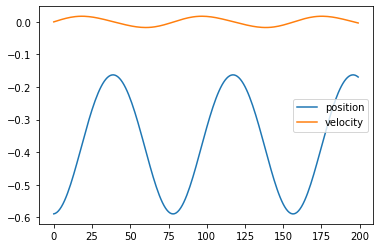

In [3]:
positions, velocities = [], []
observation = env.reset()
while True:
    positions.append(observation[0])
    velocities.append(observation[1])
    next_observation, reward, done, _ = env.step(2)
    if done:
        break
    observation = next_observation

if next_observation[0] > 0.5:
    logging.info('succeed')
else:
    logging.info('fail')

# plot positions and velocities
fig, ax = plt.subplots()
ax.plot(positions, label='position')
ax.plot(velocities, label='velocity')
ax.legend()

### SARSA with Tile Coding

Tile Coder

In [4]:
class TileCoder:
    def __init__(self, layer_count, feature_count):
        self.layer_count = layer_count
        self.feature_count = feature_count
        self.codebook = {}

    def get_feature(self, codeword):
        if codeword in self.codebook:
            return self.codebook[codeword]
        count = len(self.codebook)
        if count >= self.feature_count: # resolve conflicts
            return hash(codeword) % self.feature_count
        self.codebook[codeword] = count
        return count

    def __call__(self, floats=(), ints=()):
        dim = len(floats)
        scaled_floats = tuple(f * (self.layer_count ** 2) for f in floats)
        features = []
        for layer in range(self.layer_count):
            codeword = (layer,) + tuple(
                    int((f + (1 + dim * i) * layer) / self.layer_count)
                    for i, f in enumerate(scaled_floats)) + ints
            feature = self.get_feature(codeword)
            features.append(feature)
        return features

SARSA with Linear Approximation

In [5]:
class SARSAAgent:
    def __init__(self, env):
        self.action_n = env.action_space.n
        self.obs_low = env.observation_space.low
        self.obs_scale = env.observation_space.high - \
                env.observation_space.low
        self.encoder = TileCoder(8, 1896)
        self.w = np.zeros(self.encoder.feature_count)
        self.gamma = 1.
        self.learning_rate = 0.03

    def encode(self, observation, action):
        states = tuple((observation - self.obs_low) / self.obs_scale)
        actions = (action,)
        return self.encoder(states, actions)

    def get_q(self, observation, action): # action value
        features = self.encode(observation, action)
        return self.w[features].sum()

    def reset(self, mode=None):
        self.mode = mode
        if self.mode == 'train':
            self.trajectory = []

    def step(self, observation, reward, done):
        if self.mode == 'train' and np.random.rand() < 0.001:
            action = np.random.randint(self.action_n)
        else:
            qs = [self.get_q(observation, action) for action in
                    range(self.action_n)]
            action = np.argmax(qs)
        if self.mode == 'train':
            self.trajectory += [observation, reward, done, action]
            if len(self.trajectory) >= 8:
                self.learn()
        return action

    def close(self):
        pass

    def learn(self):
        observation, _, _, action, next_observation, reward, done, \
                next_action = self.trajectory[-8:]
        target = reward + (1. - done) * self.gamma * \
                self.get_q(next_observation, next_action)
        td_error = target - self.get_q(observation, action)
        features = self.encode(observation, action)
        self.w[features] += (self.learning_rate * td_error)


agent = SARSAAgent(env)

Train & test

23:39:42 [INFO] ==== train ====
23:41:36 [INFO] ==== test ====
23:41:39 [INFO] average episode reward = -104.65 ± 12.67


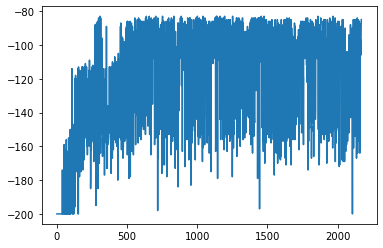

In [6]:
def play_episode(env, agent, max_episode_steps=None, mode=None, render=False):
    observation, reward, done = env.reset(), 0., False
    agent.reset(mode=mode)
    episode_reward, elapsed_steps = 0., 0
    while True:
        action = agent.step(observation, reward, done)
        if render:
            env.render()
        if done:
            break
        observation, reward, done, _ = env.step(action)
        episode_reward += reward
        elapsed_steps += 1
        if max_episode_steps and elapsed_steps >= max_episode_steps:
            break
    agent.close()
    return episode_reward, elapsed_steps


logging.info('==== train ====')
episode_rewards = []
for episode in itertools.count():
    episode_reward, elapsed_steps = play_episode(env.unwrapped, agent,
            max_episode_steps=env._max_episode_steps, mode='train')
    episode_rewards.append(episode_reward)
    logging.debug('train episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
    if np.mean(episode_rewards[-100:]) > -110:
        break
plt.plot(episode_rewards)


logging.info('==== test ====')
episode_rewards = []
for episode in range(100):
    episode_reward, elapsed_steps = play_episode(env, agent)
    episode_rewards.append(episode_reward)
    logging.debug('test episode %d: reward = %.2f, steps = %d',
            episode, episode_reward, elapsed_steps)
logging.info('average episode reward = %.2f ± %.2f',
        np.mean(episode_rewards), np.std(episode_rewards))

#### Visualize

In [7]:
poses = np.linspace(env.unwrapped.min_position,
          env.unwrapped.max_position, 128)
vels = np.linspace(-env.unwrapped.max_speed, env.unwrapped.max_speed, 128)
positions, velocities = np.meshgrid(poses, vels)

Plot action value

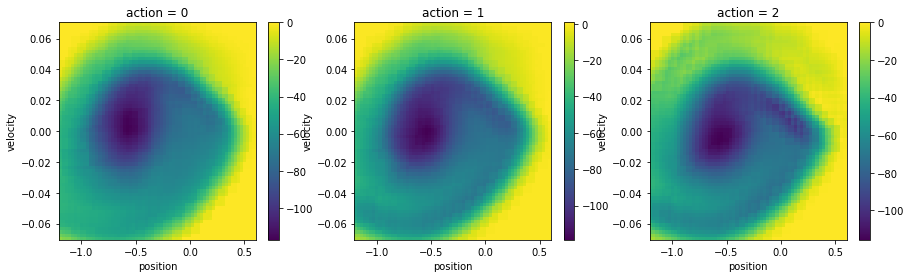

In [8]:
@np.vectorize
def get_q(position, velocity, action):
    return agent.get_q((position, velocity), action)

q_values = np.empty((len(poses), len(vels), 3))
for action in range(3):
    q_values[:, :, action] = get_q(positions, velocities, action)


fig, axes = plt.subplots(1, 3, figsize=(15, 4))
for action, ax in enumerate(axes):
    c = ax.pcolormesh(positions, velocities, q_values[:, :, action], shading='auto')
    ax.set_xlabel('position')
    ax.set_ylabel('velocity')
    fig.colorbar(c, ax=ax)
    ax.set_title('action = {}'.format(action))

Plot state value

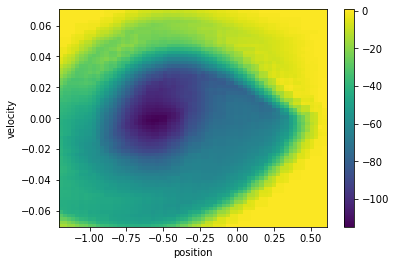

In [9]:
v_values = q_values.max(axis=-1)

fig, ax = plt.subplots(1, 1)
c = ax.pcolormesh(positions, velocities, v_values, shading='auto')
ax.set_xlabel('position')
ax.set_ylabel('velocity')
fig.colorbar(c, ax=ax);

Plot policy

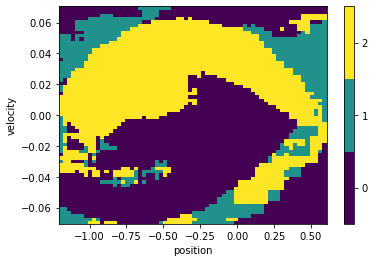

In [10]:
@np.vectorize
def decide(position, velocity):
    return agent.step((position, velocity), _, _)

q_values = np.empty((len(poses), len(vels), 3))
action_values = decide(positions, velocities)

fig, ax = plt.subplots()
c = ax.pcolormesh(positions, velocities, action_values, shading='auto')
ax.set_xlabel('position')
ax.set_ylabel('velocity')
fig.colorbar(c, ax=ax, boundaries=[-.5, .5, 1.5, 2.5], ticks=[0, 1, 2]);

In [11]:
env.close()